<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


In [1]:
import torch
import torch.nn.functional as F

# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>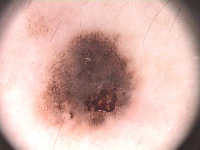</td><td>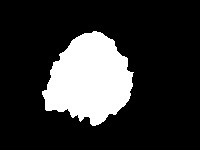</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=18747c96-a47d-4652-8abd-c51dab8b01f0
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 107MB/s]


In [3]:

get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

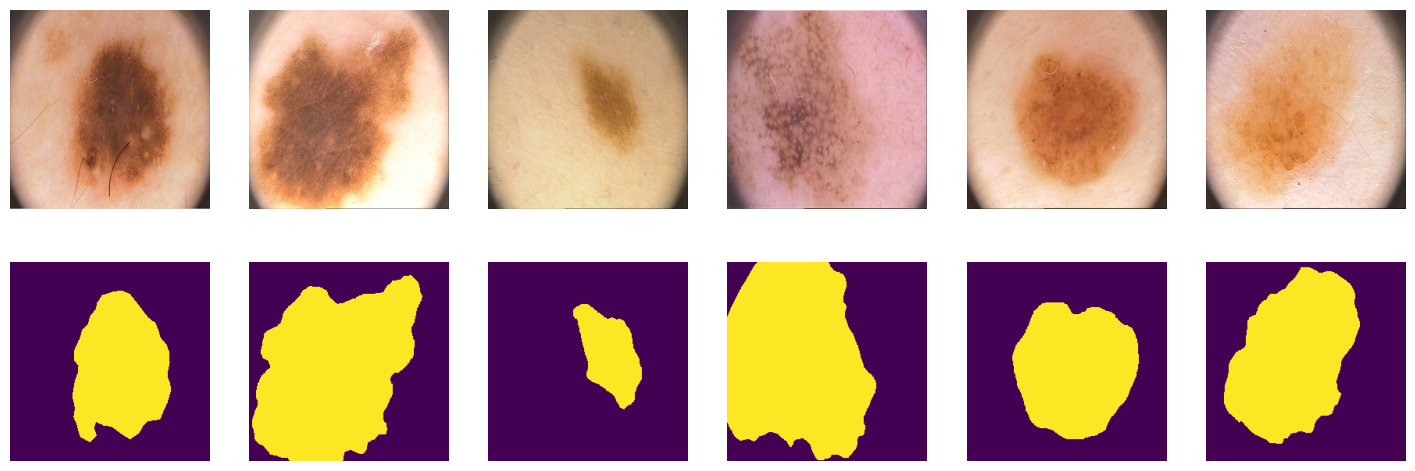

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [12]:
!pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
  loss = torch.sum(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))
  return loss

def bce_true(y_pred, y_real):
  loss = -torch.sum(y_real * torch.log(torch.sigmoid(y_pred)) + (1-y_real)* torch.log(1 - torch.sigmoid(y_pred)))
  return loss

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 6.184633255004883
BCE loss честно посчитанный                = 6.184633255004883
BCE loss from torch bce_torch              = 6.184634208679199
BCE loss from torch with logits bce_torch  = 6.184633255004883


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 12.751669883728027
BCE loss честно посчитанный               = 12.751669883728027
BCE loss from torch bce_torch             = 12.751669883728027
BCE loss from torch with logits bce_torch = 12.751669883728027


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 6.54MB/s]
Download completed


In [21]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

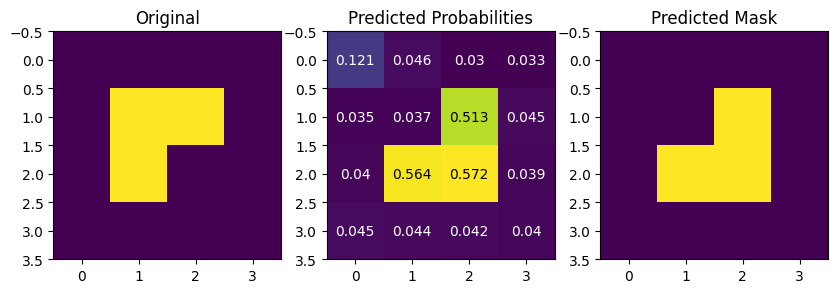

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

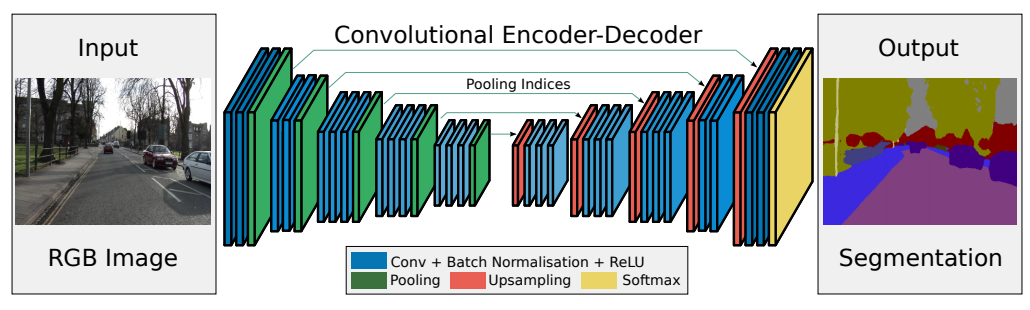

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [25]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

In [27]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [26]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [27]:
import torch
import torch.nn as nn

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth,
                 kernel_size=3, padding=1, is_last_block=False):
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                conv_in = in_channels
            else:
                conv_in = out_channels

            self.layers.append(
                nn.Conv2d(
                    in_channels=conv_in,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=padding
                )
            )

            if not (is_last_block and i == depth - 1):
                self.layers.append(nn.BatchNorm2d(out_channels))
                self.layers.append(nn.ReLU(inplace=True))

    def forward(self, x, indices, output_size=None):
        x = self.unpool(x, indices, output_size=output_size)

        for layer in self.layers:
            x = layer(x)

        return x


Соединим блоки энкодера и декодера в модель SegNet:

In [28]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)              # 3  ->  64
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)        # 64 -> 128
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=3)    # 128 -> 256
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=3)    # 256 -> 512

        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=3)    # 512 -> 512

        self.decoder0 = DecoderBlock(num_features * 8, num_features * 8, depth=3)

        self.decoder1 = DecoderBlock(num_features * 8, num_features * 4, depth=3)    # 512 -> 256
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=3)    # 256 -> 128
        self.decoder3 = DecoderBlock(num_features * 2, num_features, depth=2)        # 128 -> 64

        self.decoder4 = DecoderBlock(num_features, out_channels, depth=2,
                                     is_last_block=True)

    def forward(self, x):
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)

        x = self.decoder0(x, indices4)
        x = self.decoder1(x, indices3)
        x = self.decoder2(x, indices2)
        x = self.decoder3(x, indices1)
        x = self.decoder4(x, indices0)

        return x


## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [29]:
from tqdm.notebook import tqdm

In [30]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Обучение модели за одну эпоху с прогресс-баром.
    """
    model.train()
    running_loss = 0.0

    progress = tqdm(dataloader, desc="Train", leave=False)

    for images, masks in progress:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress.set_postfix({"loss": loss.item()})

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [31]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """
    Валидация модели за одну эпоху с прогресс-баром.
    """
    model.eval()
    running_loss = 0.0

    progress = tqdm(dataloader, desc="Val", leave=False)

    for images, masks in progress:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item() * images.size(0)
        progress.set_postfix({"loss": loss.item()})

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [32]:
def train(model,
          train_loader,
          val_loader,
          criterion,
          optimizer,
          num_epochs,
          device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 40)

        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

        val_loss = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")


    # ===== GRAPHICS =====
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Val loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    return model, history



Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SegNet(
    in_channels=3,
    out_channels=1,
    num_features=64
)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20


Using device: cuda



Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6382 | Val loss: 0.6877

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6144 | Val loss: 0.6619

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5099 | Val loss: 0.6655

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4867 | Val loss: 0.6481

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4704 | Val loss: 0.6651

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4580 | Val loss: 0.5799

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4508 | Val loss: 0.5173

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4426 | Val loss: 0.5017

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4354 | Val loss: 0.4888

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4295 | Val loss: 0.4768

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4188 | Val loss: 0.4725

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4139 | Val loss: 0.4609

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4112 | Val loss: 0.4455

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4114 | Val loss: 0.4586

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4064 | Val loss: 0.4406

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4018 | Val loss: 0.4820

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3941 | Val loss: 0.4378

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3855 | Val loss: 0.4497

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3813 | Val loss: 0.4485

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3805 | Val loss: 0.4518


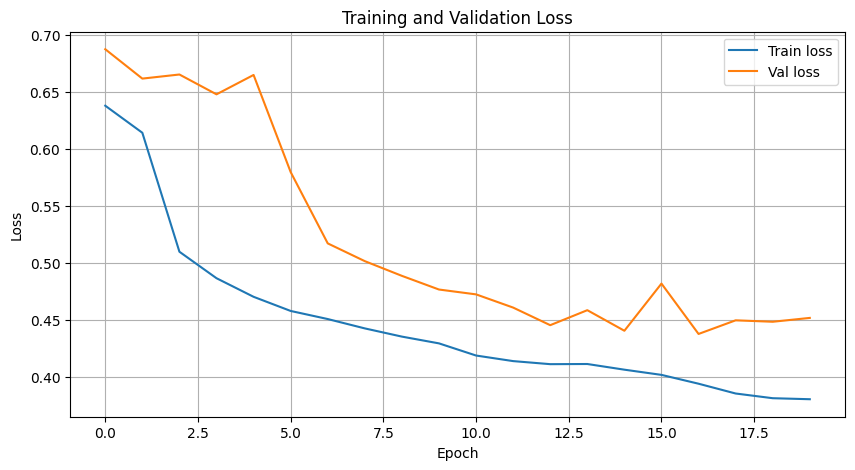

In [85]:
model, history = train(
    model=model,
    train_loader=train_dataloader,
    val_loader = valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [51]:
import random
@torch.no_grad()
def test(model,
         test_loader,
         criterion,
         device='cuda',
         visualize=True):
    model.to(device)
    model.eval()

    running_loss = 0.0
    progress = tqdm(test_loader, desc="Test", leave=False)

    batch_for_vis = None

    for images, masks in progress:
        if batch_for_vis is None:
            batch_for_vis = (images.clone(), masks.clone())

        images = images.to(device)
        masks  = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item() * images.size(0)
        progress.set_postfix({"loss": loss.item()})

    test_loss = running_loss / len(test_loader.dataset)
    print(f"\nTest loss: {test_loss:.4f}")

    if visualize:
        print("\nShowing random test example...")

        images_vis, masks_vis = batch_for_vis
        idx = random.randint(0, images_vis.size(0) - 1)

        img = images_vis[idx]
        true_mask = masks_vis[idx]

        model_output = model(img.unsqueeze(0).to(device))
        pred_mask = torch.sigmoid(model_output).cpu().squeeze(0).squeeze(0)

        img_disp = img.permute(1, 2, 0).numpy()

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(img_disp)
        axs[0].set_title("Input image")
        axs[0].axis("off")

        axs[1].imshow(true_mask.squeeze().numpy(), cmap="gray")
        axs[1].set_title("True mask")
        axs[1].axis("off")

        axs[2].imshow(pred_mask.numpy(), cmap="gray")
        axs[2].set_title("Predicted mask")
        axs[2].axis("off")

        plt.show()

    return test_loss

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.4395

Showing random test example...


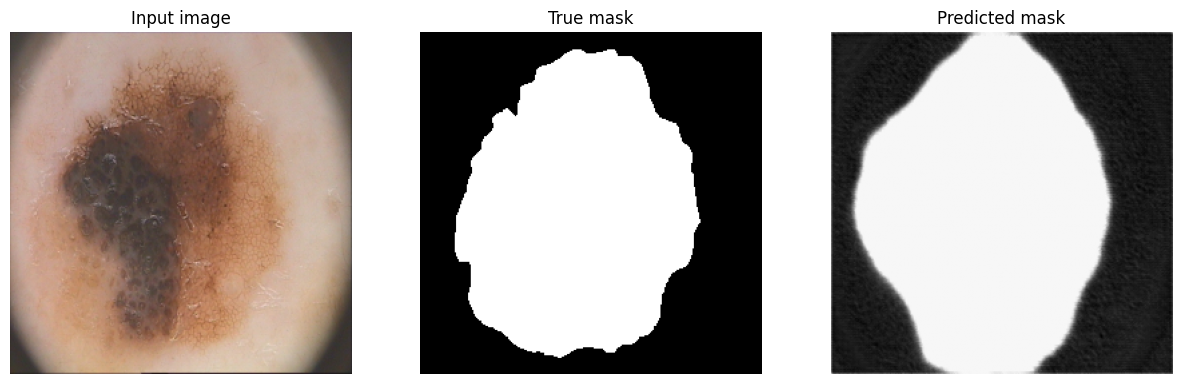

0.43950600922107697

In [120]:
test(model,test_dataloader,criterion)

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [34]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8):
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    labels = labels.float()


    preds_flat  = preds.view(preds.size(0), -1)
    labels_flat = labels.view(labels.size(0), -1)

    TP = (preds_flat * labels_flat).sum(dim=1)
    FP = (preds_flat * (1.0 - labels_flat)).sum(dim=1)
    FN = ((1.0 - preds_flat) * labels_flat).sum(dim=1)

    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    score = dice.mean()

    return score


Проверим на корректность функцию dice_score:

In [35]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.3158, device='cuda:0')

In [36]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [37]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor, eps: float = 1e-8):
    # 1. Переводим логиты в вероятности
    probs = torch.sigmoid(logits)
    labels = labels.float()

    # 2. Векторизуем
    probs_flat  = probs.view(probs.size(0), -1)
    labels_flat = labels.view(labels.size(0), -1)

    # 3. TP/FP/FN, но на вероятностях
    TP = (probs_flat * labels_flat).sum(dim=1)
    FP = (probs_flat * (1.0 - labels_flat)).sum(dim=1)
    FN = ((1.0 - probs_flat) * labels_flat).sum(dim=1)

    # 4. Dice по той же формуле
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    # 5. Dice loss
    loss = 1 - dice.mean()

    return loss


Проверка на корректность:

In [38]:
# проверьте, что у вас установлена библиотека
#!pip install segmentation-models-pytorch

In [39]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [40]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [41]:
def focal_loss(y_real, y_pred, alpha: float = -1, gamma: float = 2.0,
               reduction: str = "sum"):
    y_real = y_real.float()

    # BCE with logits, без редукции
    ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")

    # Вероятности
    p = torch.sigmoid(y_pred)

    # p_t — вероятность правильного класса
    p_t = p * y_real + (1 - p) * (1 - y_real)

    # Фокусирующий множитель
    loss = ce_loss * (1 - p_t) ** gamma

    # Альфа-вес, если alpha >= 0
    if alpha >= 0:
        alpha_t = alpha * y_real + (1 - alpha) * (1 - y_real)
        loss = alpha_t * loss

    # Редукция как в torchvision
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    elif reduction == "none":
        return loss
    else:
        raise ValueError(f"Unknown reduction: {reduction}")


Проверка корректности функции:

In [42]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [43]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [44]:
def tversky_loss(logits: torch.Tensor,
                 labels: torch.Tensor,
                 alpha: float = 0.5,
                 beta: float = 0.5,
                 eps: float = 1e-8):

    probs = torch.sigmoid(logits)
    labels = labels.float()

    probs_flat  = probs.view(probs.size(0), -1)
    labels_flat = labels.view(labels.size(0), -1)

    TP = (probs_flat * labels_flat).sum(dim=1)
    FP = (probs_flat * (1.0 - labels_flat)).sum(dim=1)
    FN = ((1.0 - probs_flat) * labels_flat).sum(dim=1)

    tversky = (TP + eps) / (TP + alpha * FP + beta * FN + eps)

    loss = 1.0 - tversky.mean()

    return loss


## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.




Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6813 | Val loss: 0.6769

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6682 | Val loss: 0.6769

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6655 | Val loss: 0.6764

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6617 | Val loss: 0.6758

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6591 | Val loss: 0.6757

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6557 | Val loss: 0.6729

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6445 | Val loss: 0.6709

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6153 | Val loss: 1.0917

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5975 | Val loss: 1.1023

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5905 | Val loss: 0.8441

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5749 | Val loss: 0.7886

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5718 | Val loss: 0.6871

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5644 | Val loss: 0.6209

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5547 | Val loss: 0.5420

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5488 | Val loss: 0.5253

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5391 | Val loss: 0.5191

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5315 | Val loss: 0.5110

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5315 | Val loss: 0.5294

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5268 | Val loss: 0.5223

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5211 | Val loss: 0.5194


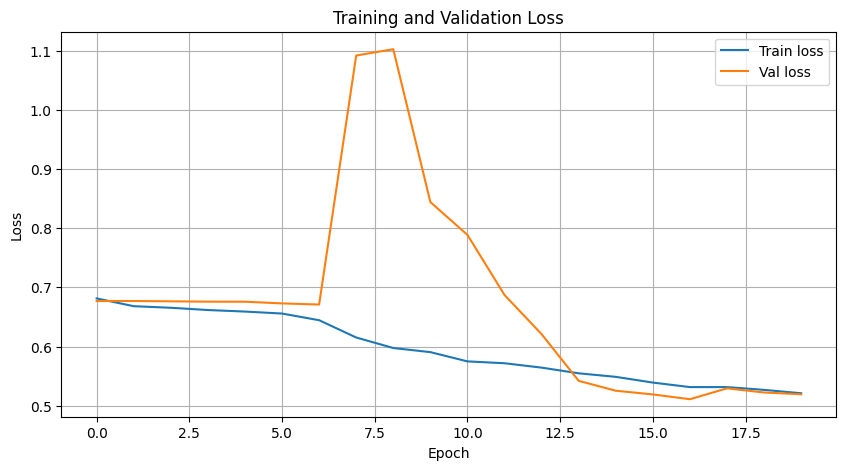

In [24]:
num_epochs = 20

# 1) BCEWithLogitsLoss
model_bce = SegNet(in_channels=3, out_channels=1)
criterion_bce = nn.BCEWithLogitsLoss()
optimizer_bce = torch.optim.Adam(model_bce.parameters(), lr=1e-3)

model_bce, history = train(
    model=model_bce,
    train_loader=train_dataloader,
    val_loader = valid_dataloader,
    criterion=criterion_bce,
    optimizer=optimizer_bce,
    num_epochs=num_epochs,
    device=device
)


Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6184 | Val loss: 0.5746

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6200 | Val loss: 0.6425

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6124 | Val loss: 0.7537

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6105 | Val loss: 0.8625

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6107 | Val loss: 0.8902

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6076 | Val loss: 0.8955

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6044 | Val loss: 0.8361

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6006 | Val loss: 0.7111

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5964 | Val loss: 0.5208

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5891 | Val loss: 0.5706

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5819 | Val loss: 0.5703

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5746 | Val loss: 0.5700

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5752 | Val loss: 0.5553

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5672 | Val loss: 0.5687

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5633 | Val loss: 0.5690

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5619 | Val loss: 0.5499

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5588 | Val loss: 0.5141

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5474 | Val loss: 0.5382

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5420 | Val loss: 0.5440

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5382 | Val loss: 0.5485


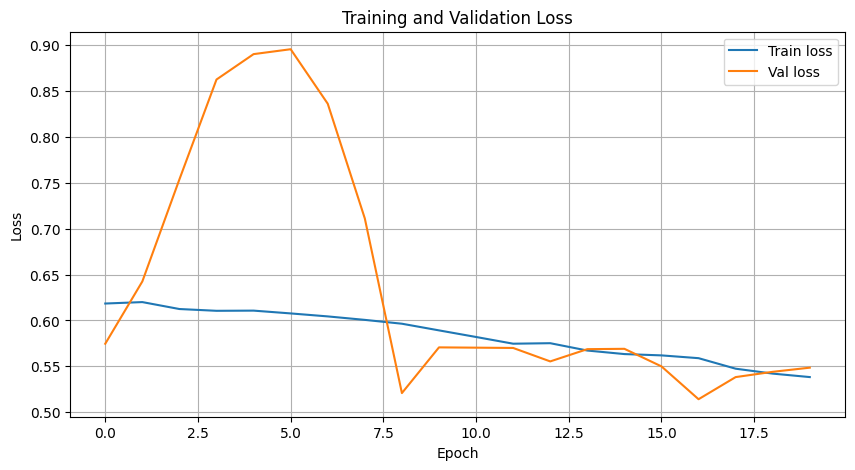

In [126]:
# 2) Dice Loss
model_dice = SegNet(in_channels=3, out_channels=1)
criterion_dice = DiceLoss(mode='binary')
optimizer_dice = torch.optim.Adam(model_dice.parameters(), lr=1e-3)

model_dice, hist_dice = train(
    model_dice,
    train_dataloader,
    valid_dataloader,
    criterion_dice,
    optimizer_dice,
    num_epochs=num_epochs,
    device=device
)



Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1674 | Val loss: 0.1655

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1622 | Val loss: 0.1658

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1613 | Val loss: 0.1652

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1603 | Val loss: 0.1652

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1595 | Val loss: 0.1649

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1584 | Val loss: 0.1646

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1564 | Val loss: 0.1637

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1523 | Val loss: 0.1635

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1437 | Val loss: 0.1676

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1360 | Val loss: 0.1673

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1297 | Val loss: 0.1544

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1262 | Val loss: 0.1629

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1225 | Val loss: 0.1560

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1178 | Val loss: 0.1574

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1170 | Val loss: 0.2081

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1158 | Val loss: 0.1934

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1136 | Val loss: 0.2147

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1119 | Val loss: 0.1601

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1081 | Val loss: 0.1617

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1056 | Val loss: 0.1298


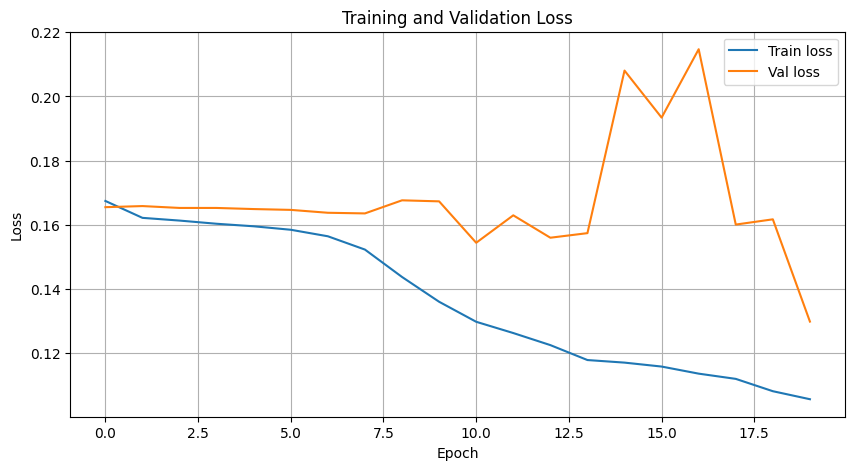

In [127]:
# 3) Focal Loss
model_focal = SegNet(in_channels=3, out_channels=1)
criterion_focal = lambda logits, labels: focal_loss(labels, logits, gamma=2.0, alpha=-1, reduction="mean")
optimizer_focal = torch.optim.Adam(model_focal.parameters(), lr=1e-3)

model_focal, hist_focal = train(
    model_focal,
    train_dataloader,
    valid_dataloader,
    criterion_focal,
    optimizer_focal,
    num_epochs=num_epochs,
    device=device
)

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.4071

Showing random test example...


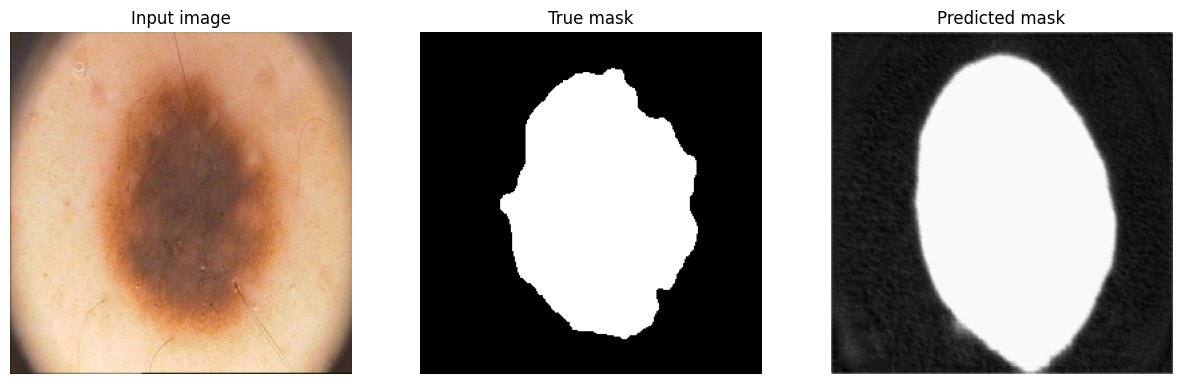

0.40710529685020447

In [131]:
test(model,test_dataloader,criterion)

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.6522

Showing random test example...


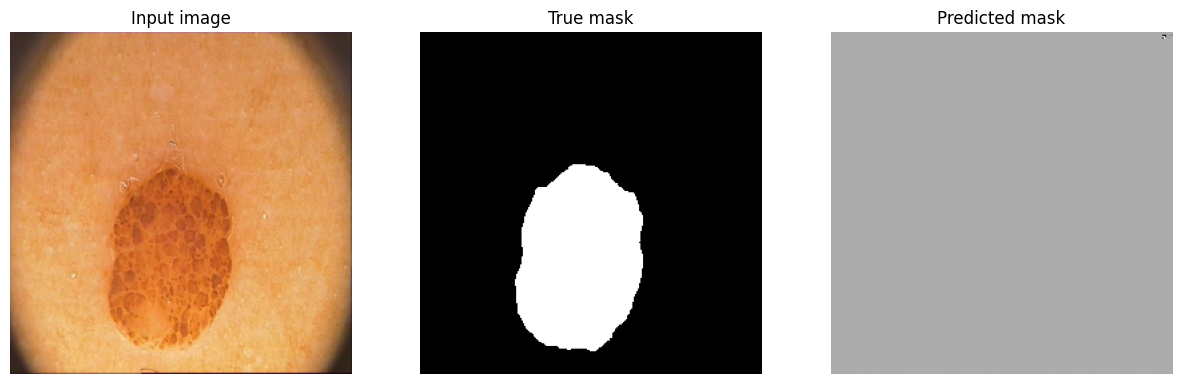

0.6521961092948914

In [132]:
test(model_dice,test_dataloader,criterion)

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.5741

Showing random test example...


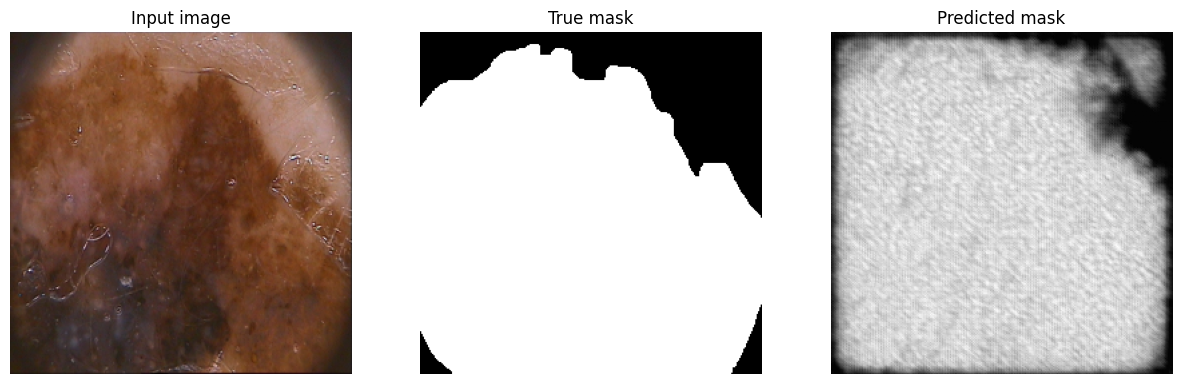

0.574118047952652

In [133]:
test(model_focal,test_dataloader,criterion)

При каком лоссе модель сходится быстрее? При BCE как видно на графиках и тесте

При каком лоссе модель выдает наилучшую метрику? Также ВСЕ

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

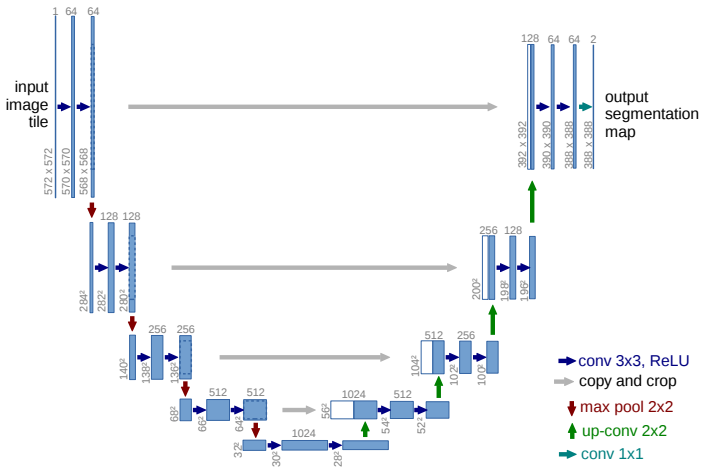

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [45]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [46]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        diff_y = skip.size(2) - x.size(2)
        diff_x = skip.size(3) - x.size(3)
        x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                      diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_class=1, in_channels=3):
        super().__init__()

        self.inc   = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)      # [B, 64,  H,   W]
        x2 = self.down1(x1)   # [B, 128, H/2, W/2]
        x3 = self.down2(x2)   # [B, 256, H/4, W/4]
        x4 = self.down3(x3)   # [B, 512, H/8, W/8]
        x5 = self.down4(x4)   # [B, 1024,H/16,W/16]

        x = self.up1(x5, x4)  # [B, 512, H/8,  W/8]
        x = self.up2(x,  x3)  # [B, 256, H/4,  W/4]
        x = self.up3(x,  x2)  # [B, 128, H/2,  W/2]
        x = self.up4(x,  x1)  # [B, 64,  H,    W]

        output = self.outc(x)  # [B, n_class, H, W] — логиты

        return output


In [47]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.




Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4964 | Val loss: 0.6849

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3534 | Val loss: 0.6549

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3301 | Val loss: 0.6534

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2872 | Val loss: 0.6645

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2753 | Val loss: 0.6720

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2557 | Val loss: 0.7061

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2400 | Val loss: 0.6478

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2208 | Val loss: 0.6768

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2382 | Val loss: 0.5882

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2154 | Val loss: 0.5905

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2098 | Val loss: 0.8396

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2389 | Val loss: 0.3629

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1993 | Val loss: 0.4035

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2029 | Val loss: 0.4085

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1829 | Val loss: 0.3311

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1781 | Val loss: 0.3393

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1851 | Val loss: 0.2632

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1751 | Val loss: 0.2301

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1799 | Val loss: 0.2278

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1665 | Val loss: 0.2733


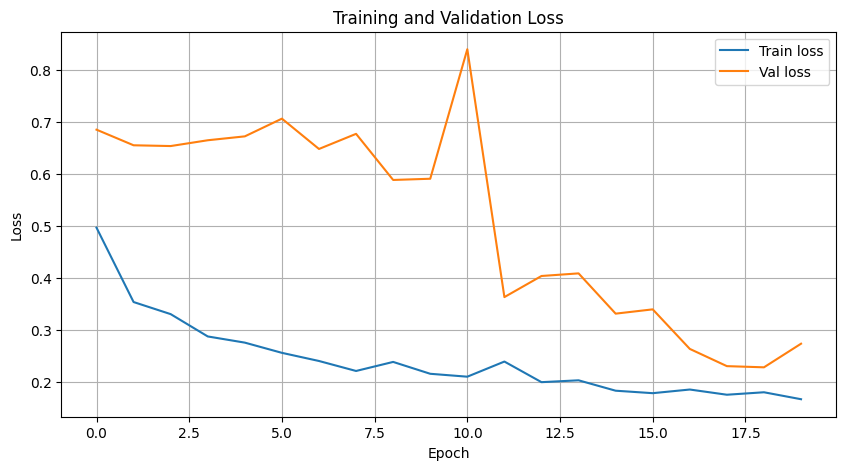

In [28]:
model_bce = UNet(in_channels=3, n_class=1)
criterion_bce = nn.BCEWithLogitsLoss()
optimizer_bce = torch.optim.Adam(model_bce.parameters(), lr=1e-3)

model, history = train(
    model=model_bce,
    train_loader=train_dataloader,
    val_loader = valid_dataloader,
    criterion=criterion_bce,
    optimizer=optimizer_bce,
    num_epochs=num_epochs,
    device=device
)

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.2209

Showing random test example...


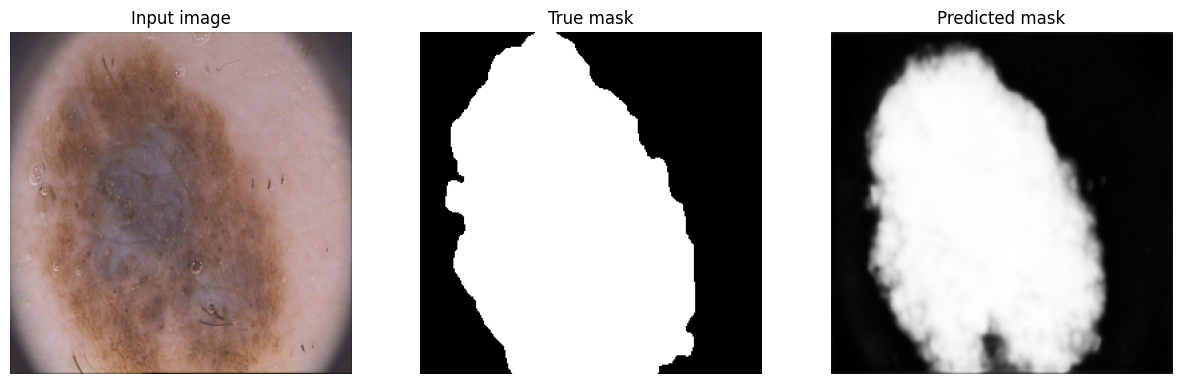

0.22094281017780304

In [32]:
test(model_bce,test_dataloader,criterion_bce)


Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4876 | Val loss: 0.5736

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3738 | Val loss: 0.5702

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3463 | Val loss: 0.4596

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3122 | Val loss: 0.9778

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2958 | Val loss: 0.7626

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2792 | Val loss: 0.6441

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2686 | Val loss: 0.3120

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2507 | Val loss: 0.3094

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2287 | Val loss: 0.3307

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2233 | Val loss: 0.2973

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2131 | Val loss: 0.1928

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2030 | Val loss: 0.2104

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2050 | Val loss: 0.3763

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1957 | Val loss: 0.2068

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1876 | Val loss: 0.1743

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1802 | Val loss: 0.1684

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1578 | Val loss: 0.1550

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1764 | Val loss: 0.2145

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1540 | Val loss: 0.1969

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1463 | Val loss: 0.1255


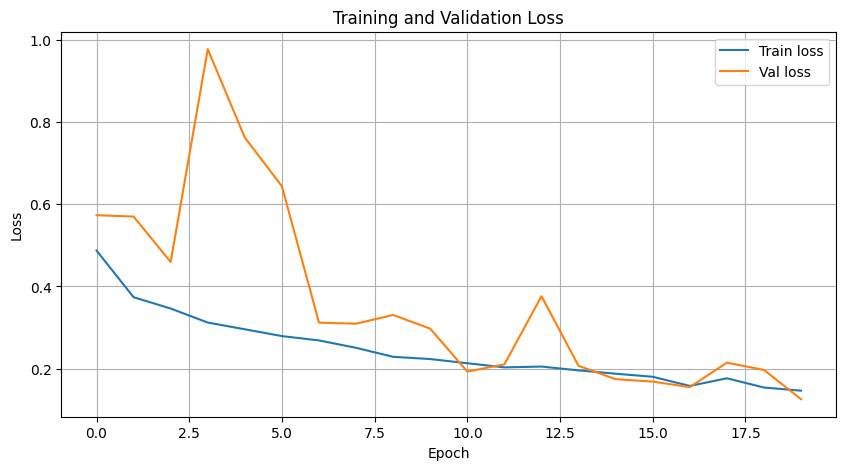

In [55]:
model_dice = UNet(in_channels=3, n_class=1)
criterion_dice = DiceLoss(mode='binary')
optimizer_dice = torch.optim.Adam(model_dice.parameters(), lr=1e-3)

model_dice, hist_dice = train(
    model_dice,
    train_dataloader,
    valid_dataloader,
    criterion_dice,
    optimizer_dice,
    num_epochs=num_epochs,
    device=device
)

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.1815

Showing random test example...


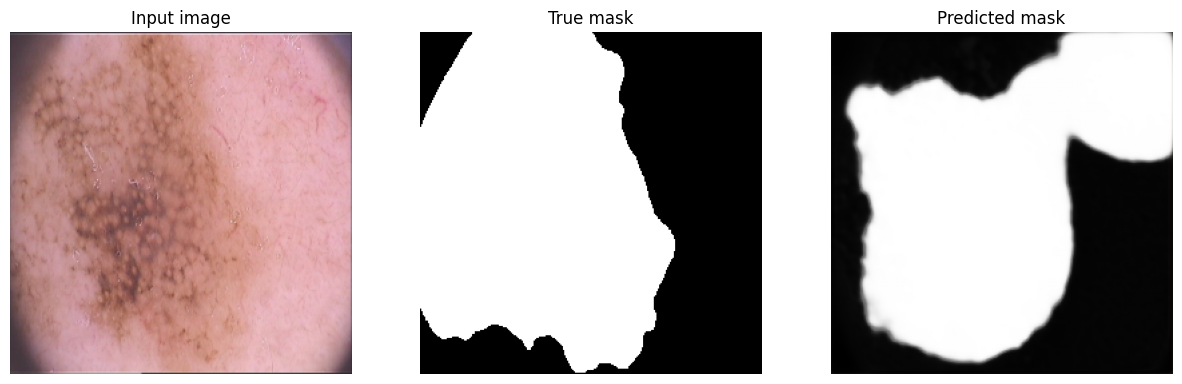

0.1814524531364441

In [56]:
test(model_dice,test_dataloader,criterion_dice)

In [48]:
num_epochs = 20

model_bce = UNet(in_channels=3, n_class=1)


Epoch 1/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1445 | Val loss: 0.1605

Epoch 2/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0919 | Val loss: 0.1688

Epoch 3/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0746 | Val loss: 0.1645

Epoch 4/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0748 | Val loss: 0.2416

Epoch 5/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0635 | Val loss: 1.2063

Epoch 6/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0630 | Val loss: 0.6635

Epoch 7/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0538 | Val loss: 0.5699

Epoch 8/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0531 | Val loss: 0.0921

Epoch 9/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0494 | Val loss: 0.1246

Epoch 10/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0569 | Val loss: 0.1996

Epoch 11/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0518 | Val loss: 0.1321

Epoch 12/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0482 | Val loss: 0.0891

Epoch 13/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0467 | Val loss: 0.1053

Epoch 14/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0435 | Val loss: 0.1588

Epoch 15/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0434 | Val loss: 0.0591

Epoch 16/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0432 | Val loss: 0.0530

Epoch 17/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0476 | Val loss: 0.0866

Epoch 18/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0409 | Val loss: 0.1191

Epoch 19/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0412 | Val loss: 0.0771

Epoch 20/20
----------------------------------------


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0422 | Val loss: 0.0489


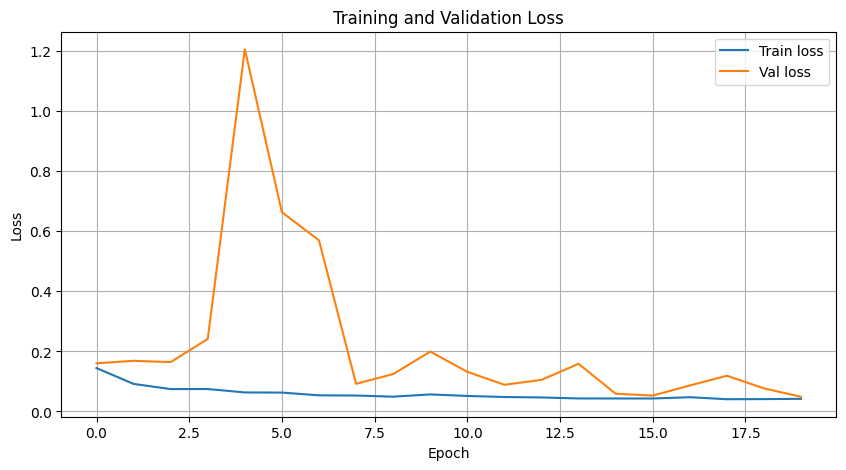

In [49]:
criterion_focal = lambda logits, labels: focal_loss(labels, logits, gamma=2.0, alpha=-1, reduction="mean")
optimizer_focal = torch.optim.Adam(model_bce.parameters(), lr=1e-3)

model_focal, hist_focal = train(
    model_bce,
    train_dataloader,
    valid_dataloader,
    criterion_focal,
    optimizer_focal,
    num_epochs=num_epochs,
    device=device
)

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Test loss: 0.2469

Showing random test example...


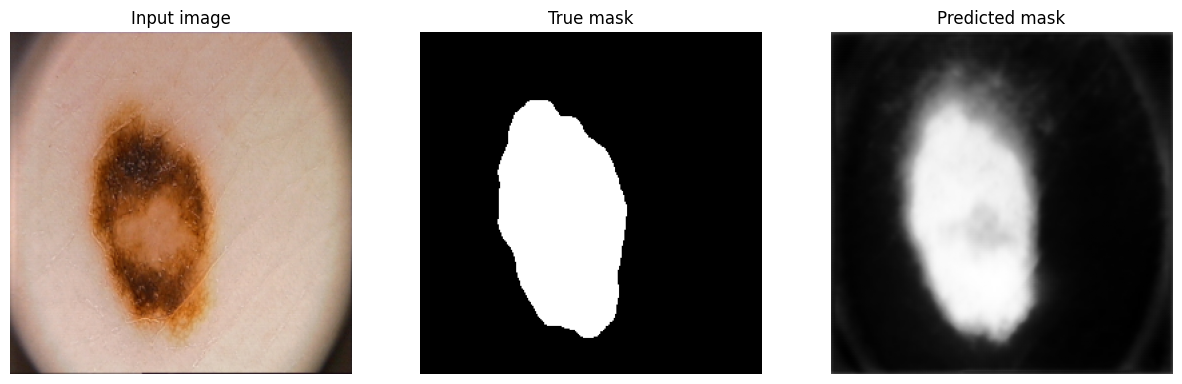

0.24692907184362411

In [52]:
test(model_focal,test_dataloader,criterion)